### Visualization for belief partition decoding, combined across both trial events
- interested also in subpopulation defined with either combination of 95th or 99th sig level for belief partitions, across both trial events

### Imports

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy

In [13]:
def plot_combined_accs(args):
    stim_args = copy.deepcopy(args)
    stim_args.trial_event = "StimOnset"
    stim_res = belief_partitions_io.read_results(stim_args, FEATURES)
    print(stim_res.feat.unique())
    # stim_res = stim_res[stim_res.feat != "GREEN"]

    fb_args = copy.deepcopy(args)
    fb_args.trial_event = "FeedbackOnsetLong"
    fb_res = belief_partitions_io.read_results(fb_args, FEATURES)
    # fb_res = fb_res[fb_res.feat != "GREEN"]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey='row', width_ratios=[stim_res.Time.nunique(), fb_res.Time.nunique()])

    visualization_utils.visualize_preferred_beliefs(stim_args, stim_res, ax1, hue_col="mode")
    ax1.set_xlabel(f"Time Relative to Stim Onset")

    visualization_utils.visualize_preferred_beliefs(fb_args, fb_res, ax2, hue_col="mode")
    ax2.set_xlabel(f"Time Relative to Feedback Onset")

    fig.tight_layout()

def plot_combined_cross_accs(args):
    args.trial_event = "StimOnset"
    stim_res = belief_partitions_io.read_results(args, FEATURES)
    cross_stim_res = belief_partitions_io.read_cross_time_results(args, FEATURES, avg=True)
    args.model_trial_event = "FeedbackOnsetLong"
    fb_model_cross_stim_res = belief_partitions_io.read_cross_time_results(args, FEATURES, avg=True)
    args.model_trial_event = None


    args.trial_event = "FeedbackOnsetLong"
    fb_res = belief_partitions_io.read_results(args, FEATURES)
    cross_fb_res = belief_partitions_io.read_cross_time_results(args, FEATURES, avg=True)
    args.model_trial_event = "StimOnset"
    stim_model_cross_fb_res = belief_partitions_io.read_cross_time_results(args, FEATURES, avg=True)
    args.model_trial_event = None

    fig, axs = plt.subplots(
        2, 2, figsize=(11, 10),                            
        width_ratios=[cross_stim_res.TestTime.nunique(), cross_fb_res.TestTime.nunique()],
        height_ratios=[cross_stim_res.TestTime.nunique(), cross_fb_res.TestTime.nunique()],
        sharex="col",
        sharey="row",
    )
    all_res = pd.concat((cross_stim_res, stim_model_cross_fb_res, fb_model_cross_stim_res, cross_fb_res))
    all_max = all_res.groupby(["TestTime", "TrainTime"]).Accuracy.mean().max()
    print(all_max)

    all_decoder_res = pd.concat((stim_res, fb_res))
    shuffles = all_decoder_res[all_decoder_res["mode"] == f"{args.mode}_shuffle"]
    shuffle_means = shuffles.groupby(["Time"]).Accuracy.mean().reset_index(name="ShuffleAccuracy")
    all_min = shuffle_means.ShuffleAccuracy.min()

    # visualization_utils.visualize_cross_time(args, cross_stim_res, stim_res, axs[0, 0])
    # visualization_utils.visualize_cross_time(args, stim_model_cross_fb_res, fb_res, axs[0, 1])
    # visualization_utils.visualize_cross_time(args, fb_model_cross_stim_res, stim_res, axs[1, 0])
    # visualization_utils.visualize_cross_time(args, cross_fb_res, fb_res, axs[1, 1])

    visualization_utils.visualize_cross_time(args, cross_stim_res, stim_res, axs[0, 0], cbar=False, vmin=all_min, vmax=all_max)
    visualization_utils.visualize_cross_time(args, stim_model_cross_fb_res, fb_res, axs[0, 1], cbar=False, vmin=all_min, vmax=all_max)
    visualization_utils.visualize_cross_time(args, fb_model_cross_stim_res, stim_res, axs[1, 0], cbar=False, vmin=all_min, vmax=all_max)
    visualization_utils.visualize_cross_time(args, cross_fb_res, fb_res, axs[1, 1], cbar=False, vmin=all_min, vmax=all_max)

    # Adjust subplots to make space for colorbar
    fig.subplots_adjust(right=0.85)

    # Create a single colorbar to the right of ax2
    cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(axs[1, 1].collections[0], cax=cbar_ax, orientation='vertical')
    cbar.set_label('Accuracy')
    # fig.tight_layout()



### SA, Pref, belief_partition_all_time_99th

Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9


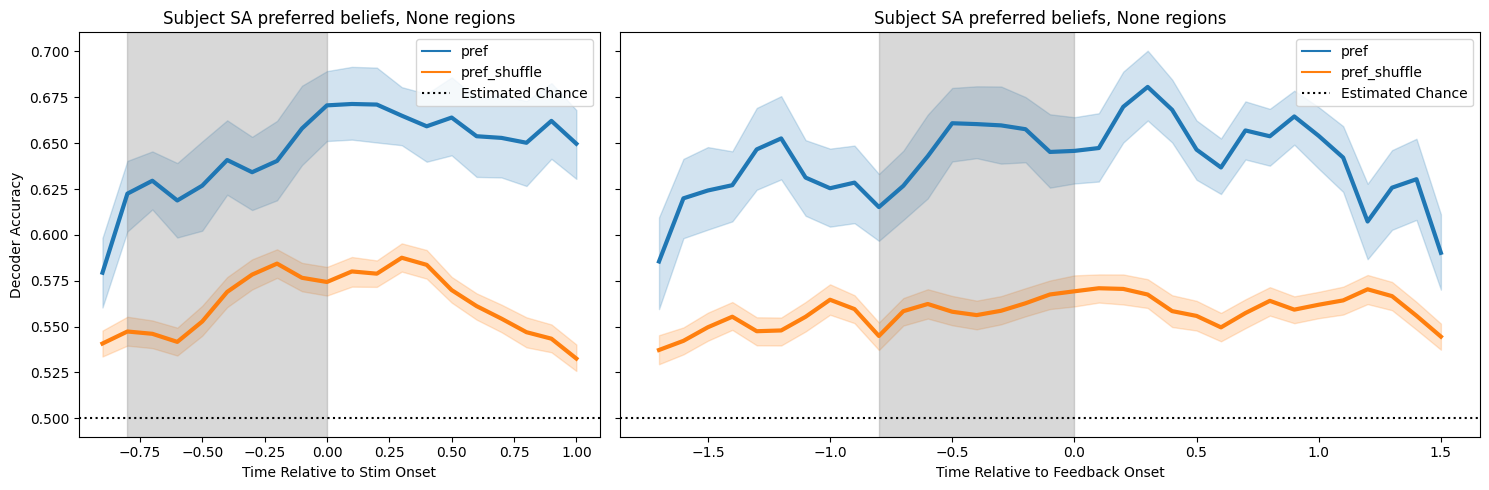

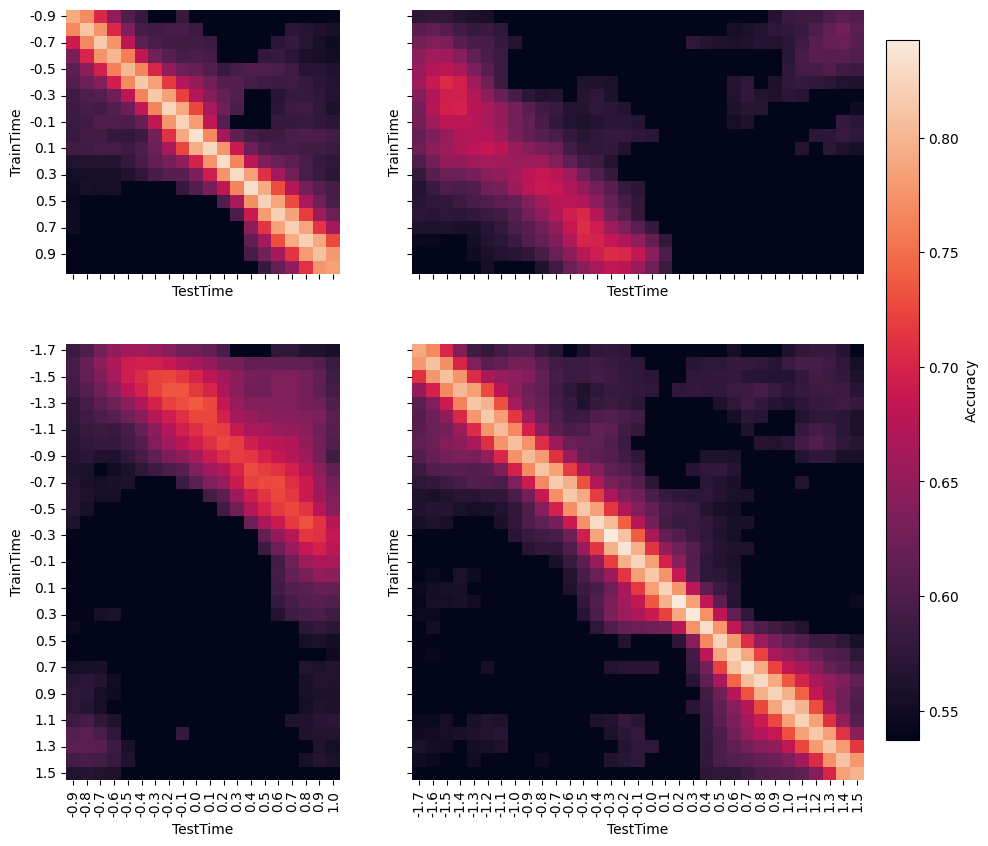

In [4]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_all_time_99th"

plot_combined_accs(args)
plot_combined_cross_accs(args)



### SA, Conf, belief partition all time 99th

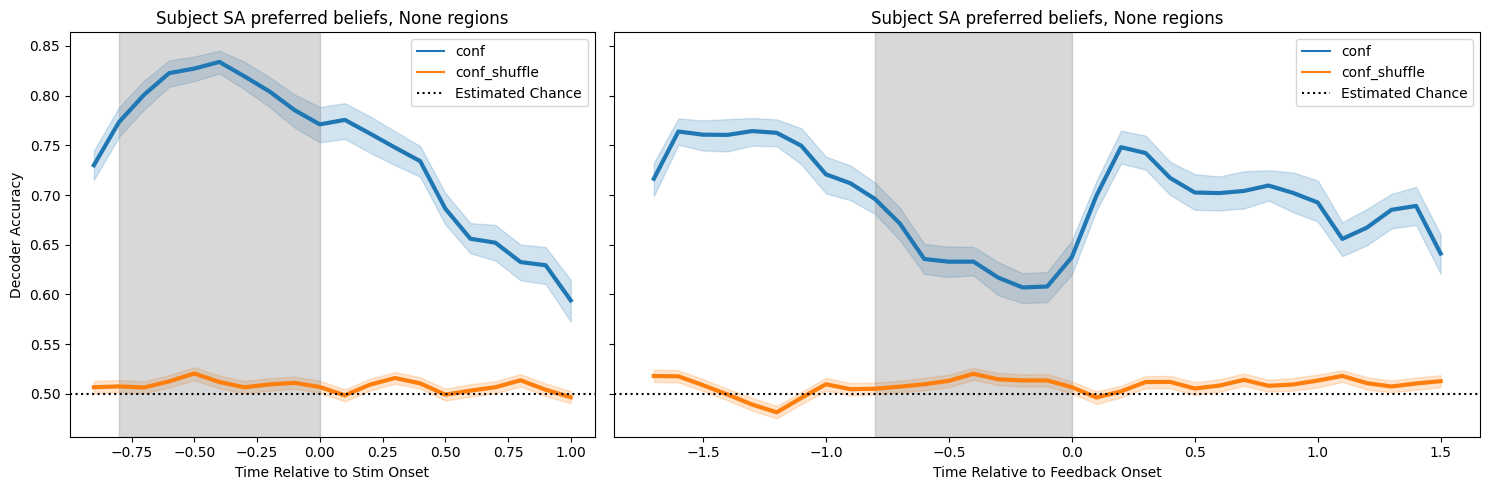

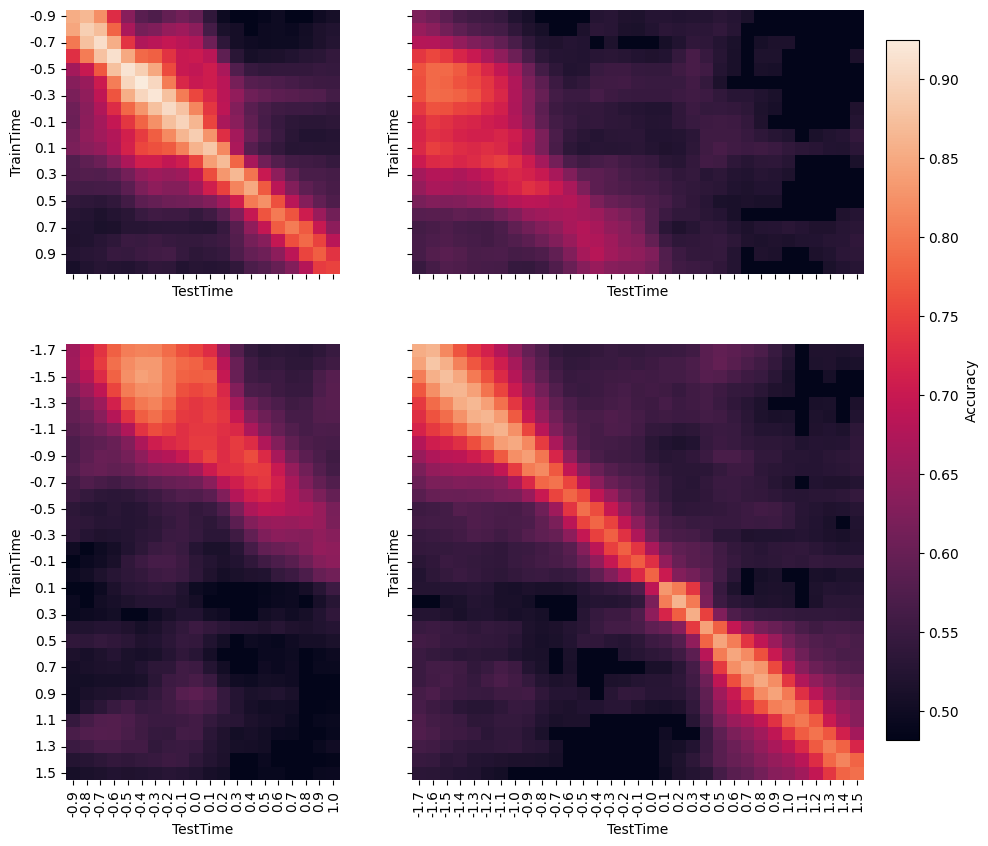

In [8]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "conf"
args.sig_unit_level = "belief_partition_all_time_99th"

plot_combined_accs(args)
plot_combined_cross_accs(args)


### SA, Pref, belief_partition_all_time_95th

Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
['CIRCLE' 'SQUARE' 'STAR' 'TRIANGLE' 'CYAN' 'GREEN' 'MAGENTA' 'YELLOW'
 'ESCHER' 'POLKADOT' 'RIPPLE' 'SWIRL']
Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not foun

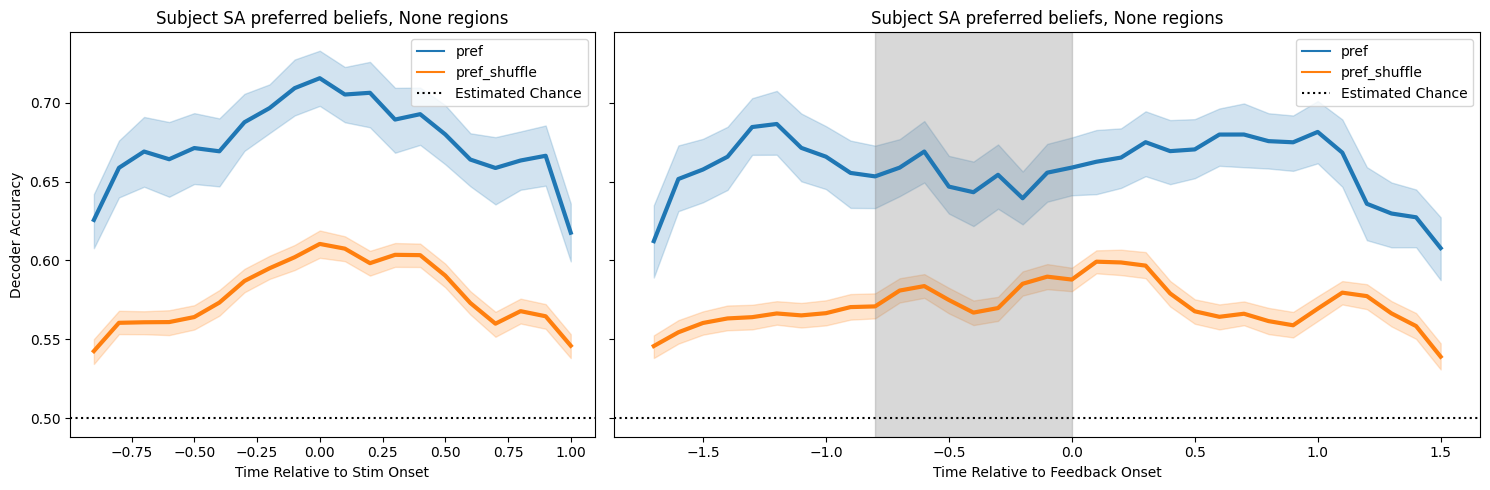

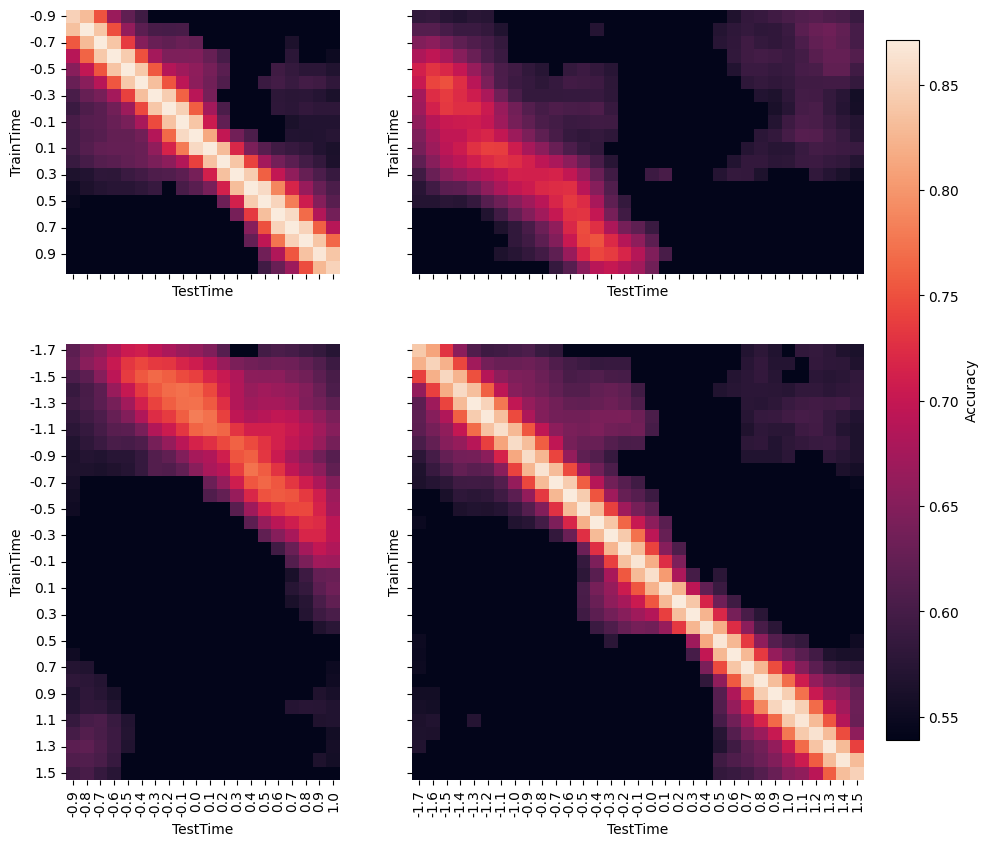

In [14]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
plot_combined_cross_accs(args)


### Debug:

In [18]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_all_time_95th"
args.trial_event = "StimOnset"
fb_res = belief_partitions_io.read_results(args, FEATURES)
cross_fb_res = belief_partitions_io.read_cross_time_results(args, FEATURES, avg=False)

Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9


In [19]:
fb_res

,Time,run,Accuracy,mode,feat
0,-0.9,0,0.7225,pref,CIRCLE
1,-0.8,0,0.7675,pref,CIRCLE
2,-0.7,0,0.7350,pref,CIRCLE
3,-0.6,0,0.5275,pref,CIRCLE
4,-0.5,0,0.4200,pref,CIRCLE
...,...,...,...,...,...
155,0.6,7,0.6825,pref_shuffle,SWIRL
156,0.7,7,0.4425,pref_shuffle,SWIRL
157,0.8,7,0.5600,pref_shuffle,SWIRL
158,0.9,7,0.5000,pref_shuffle,SWIRL


In [17]:
cross_fb_res

,TrainTime,TestTime,RunIdx,Feat,Accuracy
0,-1.7,-1.7,0,CIRCLE,0.9400
1,-1.7,-1.7,1,CIRCLE,0.8300
2,-1.7,-1.7,2,CIRCLE,0.8825
3,-1.7,-1.7,3,CIRCLE,0.7925
4,-1.7,-1.7,4,CIRCLE,0.9175
...,...,...,...,...,...
104539,1.5,1.5,3,SWIRL,0.8275
104540,1.5,1.5,4,SWIRL,0.8975
104541,1.5,1.5,5,SWIRL,0.7950
104542,1.5,1.5,6,SWIRL,0.8925


### SA, Conf, belief partition all time 95th

['CIRCLE' 'SQUARE' 'STAR' 'TRIANGLE' 'CYAN' 'GREEN' 'MAGENTA' 'YELLOW'
 'ESCHER' 'POLKADOT' 'RIPPLE' 'SWIRL']


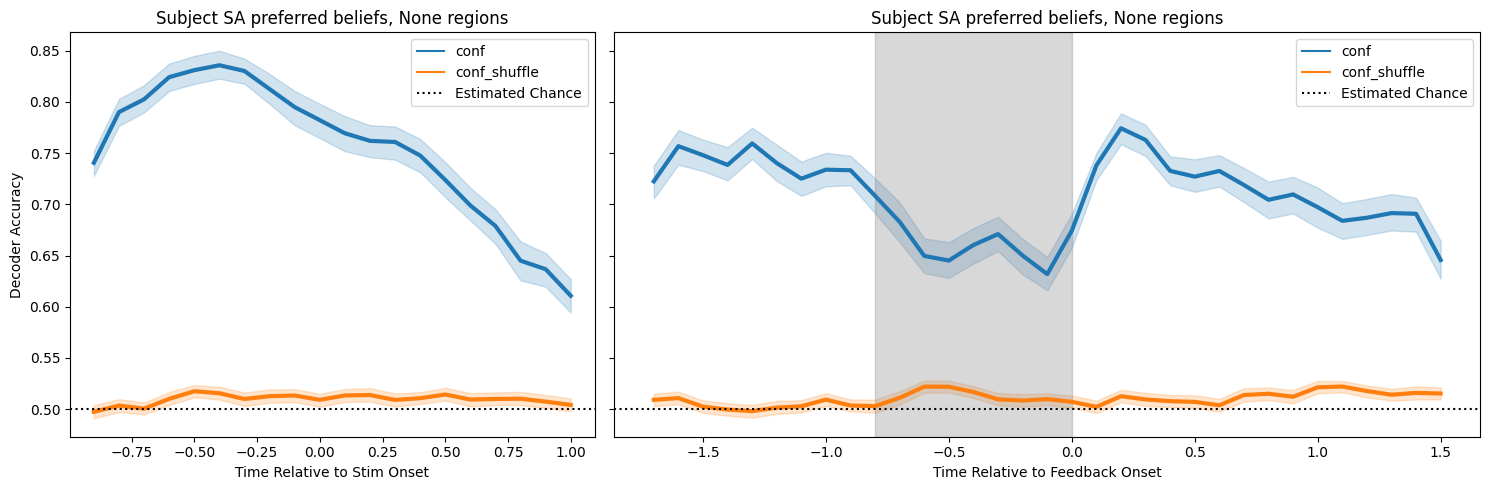

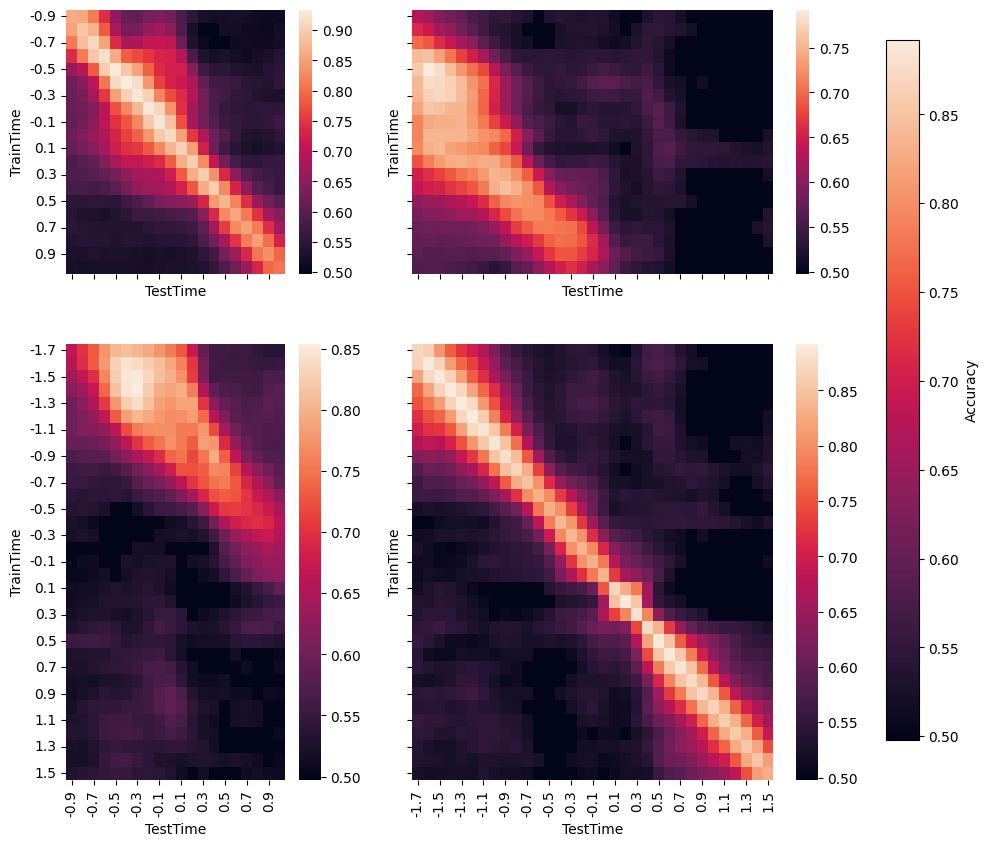

In [50]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "conf"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
plot_combined_cross_accs(args)


### SA, Temporal, Pref, 95th

Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENTA_pref_shuffle_3
Warning, shuffle not found: MAGENTA_pref_shuffle_6
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
Warning, shuffle not found: MAGENTA_pref_shuffle_0
Warning, shuffle not found: MAGENT

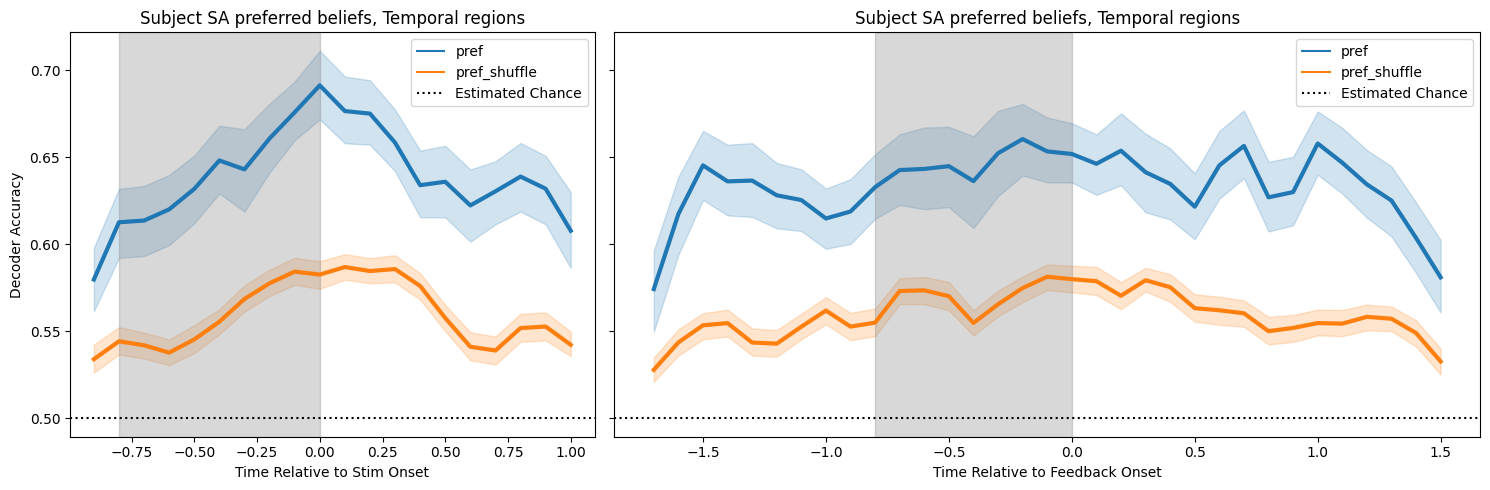

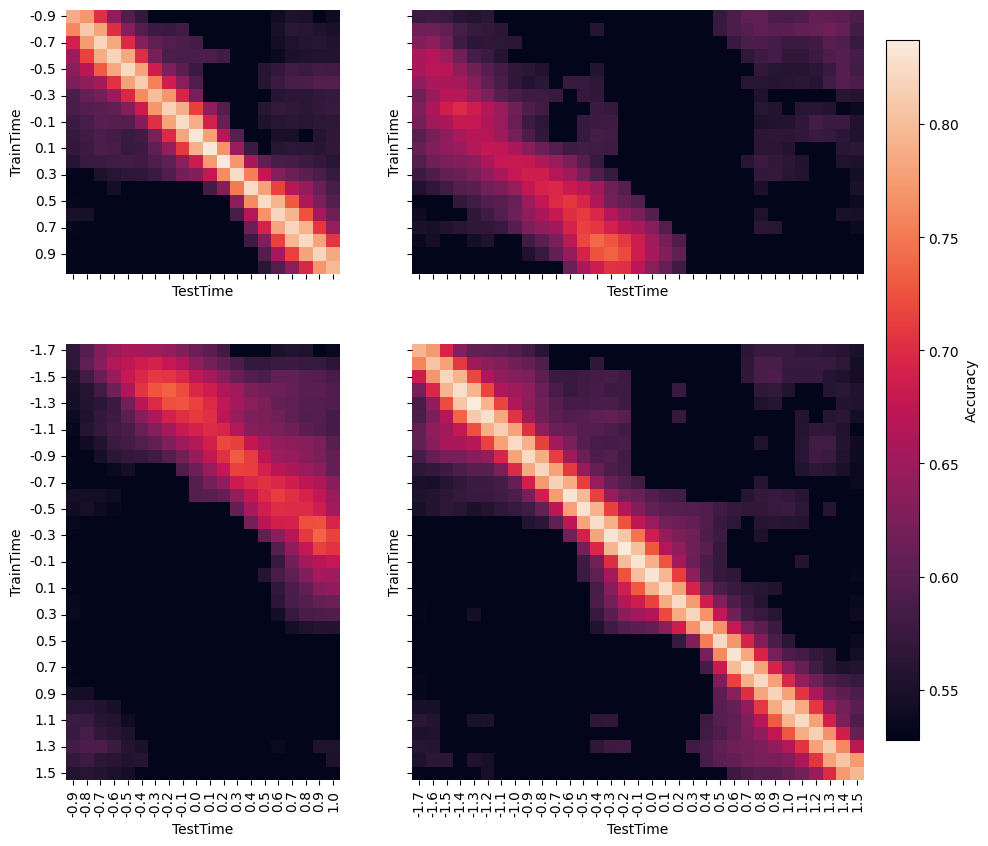

In [4]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "SA"
args.region_level = "drive"
args.regions = "Temporal"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
plot_combined_cross_accs(args)


### SA, Temporal, Conf, 95th

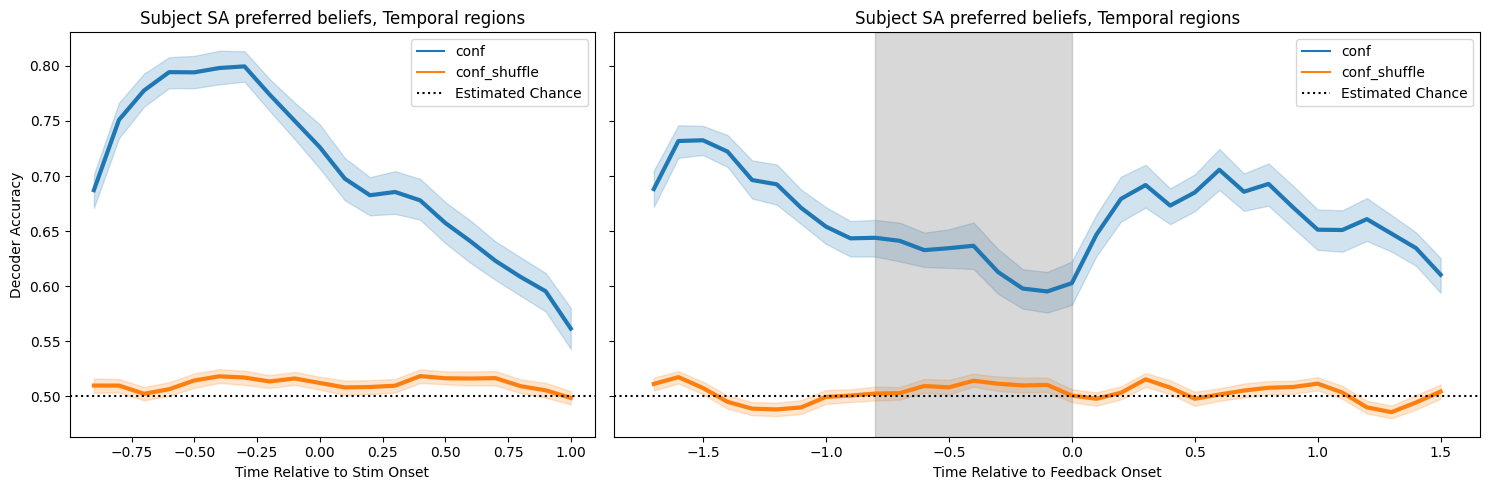

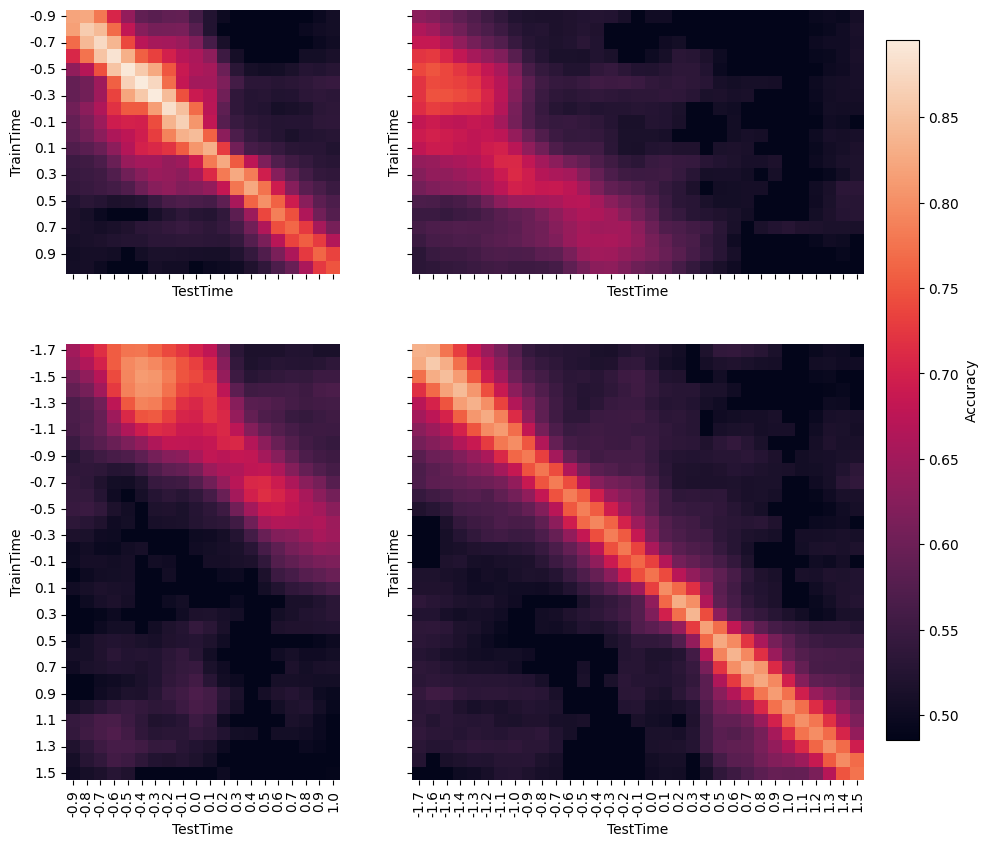

In [7]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "SA"
args.region_level = "drive"
args.regions = "Temporal"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "conf"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
plot_combined_cross_accs(args)

### SA, Anterior, Pref, 95th

Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9
['CIRCLE' 'SQUARE' 'STAR' 'TRIANGLE' 'CYAN' 'GREEN' 'MAGENTA' 'YELLOW'
 'ESCHER' 'POLKADOT' 'RIPPLE' 'SWIRL']
Warning, shuffle not found: MAGENTA_pref_shuffle_7
Warning, shuffle not found: MAGENTA_pref_shuffle_9
Warning, shuffle not found: RIPPLE_pref_shuffle_9


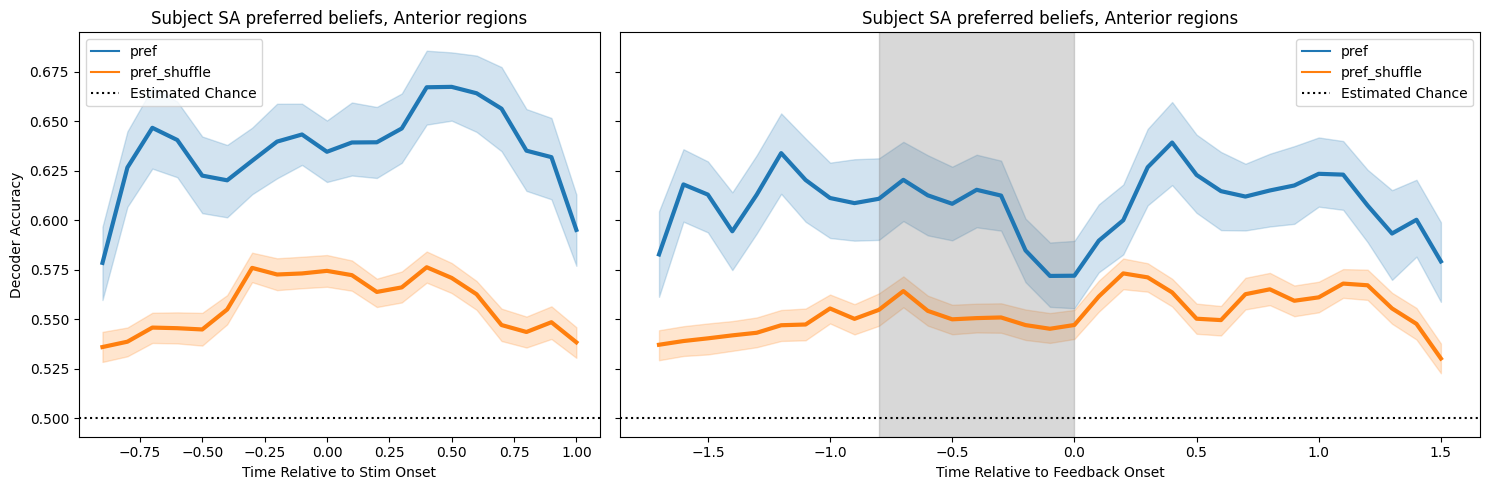

In [45]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "SA"
args.region_level = "drive"
args.regions = "Anterior"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
# plot_combined_cross_accs(args)


### SA, Anterior, conf, 95th

['CIRCLE' 'SQUARE' 'STAR' 'TRIANGLE' 'CYAN' 'GREEN' 'MAGENTA' 'YELLOW'
 'ESCHER' 'POLKADOT' 'RIPPLE' 'SWIRL']


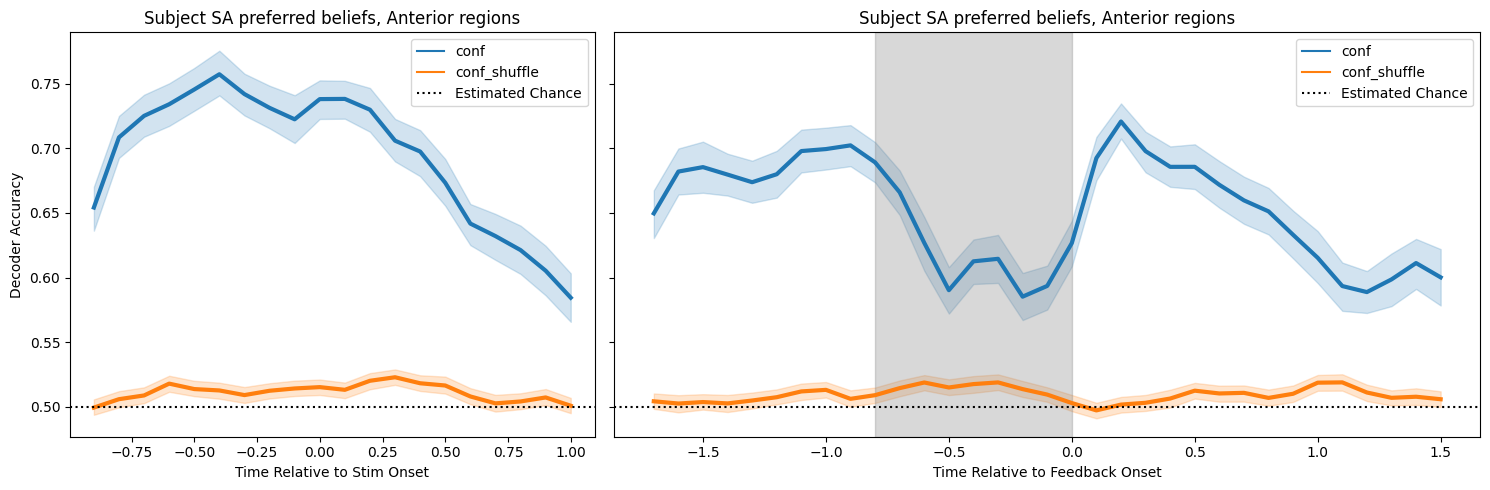

In [46]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "SA"
args.region_level = "drive"
args.regions = "Anterior"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "conf"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
# plot_combined_cross_accs(args)


### BL, Pref, 95th

Warning, shuffle not found: GREEN_pref_shuffle_0
Warning, shuffle not found: GREEN_pref_shuffle_1
Warning, shuffle not found: GREEN_pref_shuffle_2
Warning, shuffle not found: GREEN_pref_shuffle_3
Warning, shuffle not found: GREEN_pref_shuffle_4
Warning, shuffle not found: GREEN_pref_shuffle_5
Warning, shuffle not found: STAR_pref_shuffle_6
Warning, shuffle not found: GREEN_pref_shuffle_6
Warning, shuffle not found: GREEN_pref_shuffle_7
Warning, shuffle not found: GREEN_pref_shuffle_8
Warning, shuffle not found: GREEN_pref_shuffle_9
['CIRCLE' 'SQUARE' 'STAR' 'TRIANGLE' 'CYAN' 'GREEN' 'MAGENTA' 'YELLOW'
 'ESCHER' 'POLKADOT' 'RIPPLE' 'SWIRL']
Warning, shuffle not found: GREEN_pref_shuffle_0
Warning, shuffle not found: GREEN_pref_shuffle_1
Warning, shuffle not found: GREEN_pref_shuffle_2
Warning, shuffle not found: GREEN_pref_shuffle_3
Warning, shuffle not found: GREEN_pref_shuffle_4
Warning, shuffle not found: GREEN_pref_shuffle_5
Warning, shuffle not found: STAR_pref_shuffle_6
Warning, s

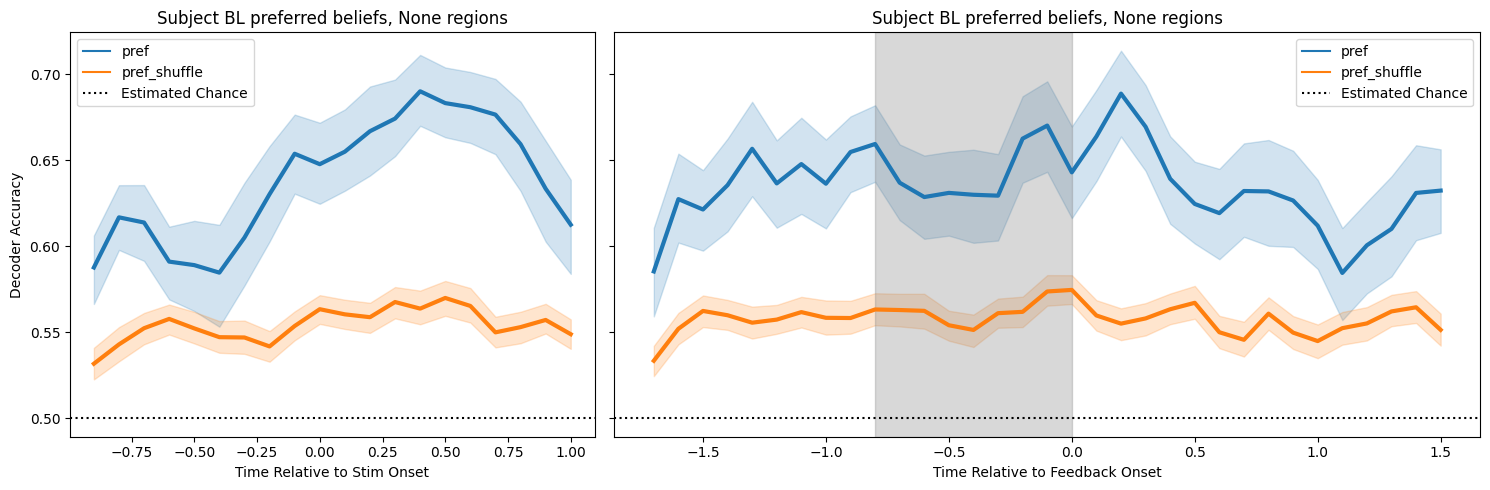

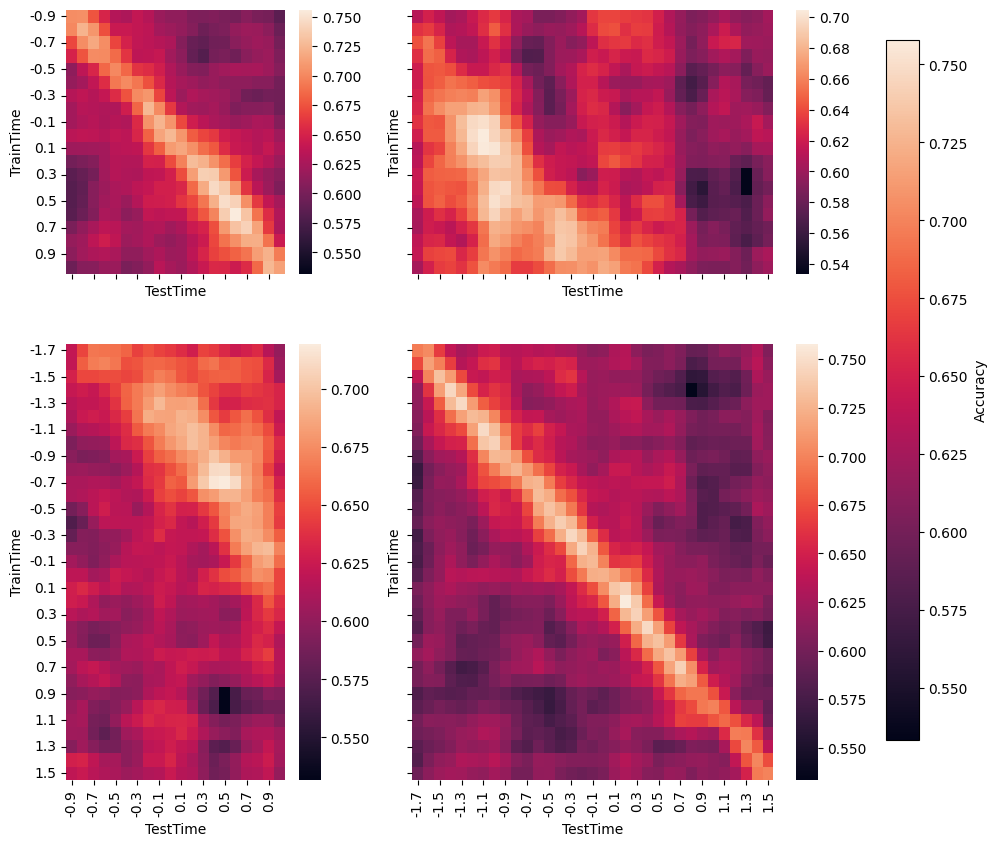

In [47]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "BL"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "pref"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
plot_combined_cross_accs(args)


### BL, conf, 95th

Warning, shuffle not found: GREEN_conf_shuffle_0
Warning, shuffle not found: GREEN_conf_shuffle_1
Warning, shuffle not found: GREEN_conf_shuffle_2
Warning, shuffle not found: GREEN_conf_shuffle_3
Warning, shuffle not found: GREEN_conf_shuffle_4
Warning, shuffle not found: GREEN_conf_shuffle_5
Warning, shuffle not found: GREEN_conf_shuffle_6
Warning, shuffle not found: GREEN_conf_shuffle_7
Warning, shuffle not found: GREEN_conf_shuffle_8
Warning, shuffle not found: GREEN_conf_shuffle_9
Warning, shuffle not found: GREEN_conf_shuffle_0
Warning, shuffle not found: GREEN_conf_shuffle_1
Warning, shuffle not found: GREEN_conf_shuffle_2
Warning, shuffle not found: GREEN_conf_shuffle_3
Warning, shuffle not found: GREEN_conf_shuffle_4
Warning, shuffle not found: GREEN_conf_shuffle_5
Warning, shuffle not found: GREEN_conf_shuffle_6
Warning, shuffle not found: GREEN_conf_shuffle_7
Warning, shuffle not found: GREEN_conf_shuffle_8
Warning, shuffle not found: GREEN_conf_shuffle_9
Warning, shuffle not

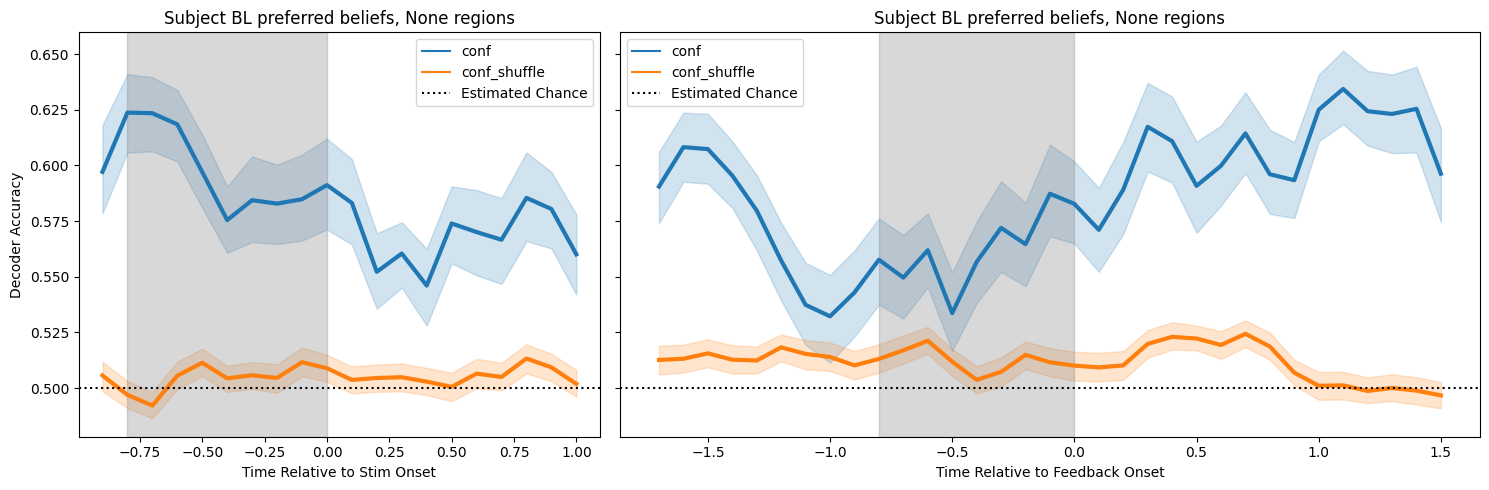

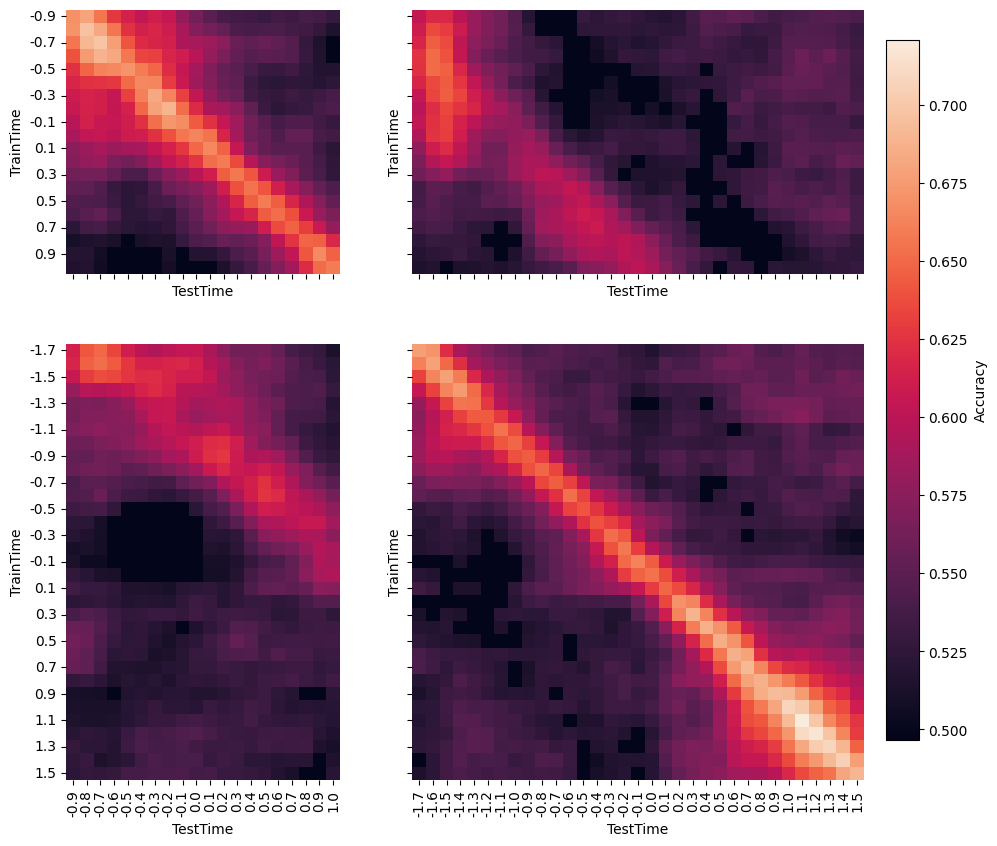

In [4]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "BL"
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.shuffle_method = "session_permute"
args.mode = "conf"
args.sig_unit_level = "belief_partition_all_time_95th"

plot_combined_accs(args)
plot_combined_cross_accs(args)
